# X-ray Image Classification

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from astropy.io import fits
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def fits_to_png(fitspath):
    hdulist = fits.open(fitspath)
    plt.figure()
    plt.imshow(hdulist[0].data)
    plt.axis('off')
    savepath = fitspath[:-5] + '.png'
    plt.savefig(savepath)
    plt.close()
    #plt.show()

## Explore images

In [2]:
# Explore dataset
data_dir = pathlib.Path("/srv/scratch/zhutchen/khess_images/")
print(data_dir)

/srv/scratch/zhutchen/khess_images


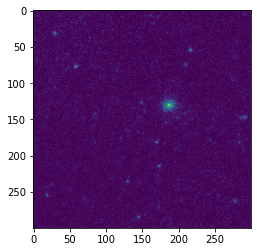

In [3]:
detections = list(data_dir.glob('detections/*'))
det0 = fits.open(detections[30])

plt.figure()
plt.imshow(det0[0].data)
plt.show()

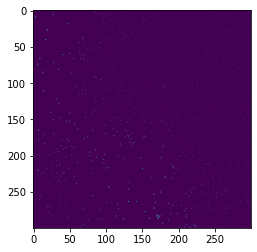

In [4]:
pcimages = list(data_dir.glob('poor_coverage/*'))
pc = fits.open(pcimages[27])

plt.figure()
plt.imshow(pc[0].data)
plt.show()

# Create PNG images from FITS

In [ ]:
detpath = "/srv/scratch/zhutchen/khess_images/detections/"
for file in os.listdir(detpath):
    if file.endswith('.fits'):
        fits_to_png(detpath+file)

In [ ]:
nondetpath = "/srv/scratch/zhutchen/khess_images/nondetections/"
for file in os.listdir(nondetpath):
    if file.endswith('.fits'):
        fits_to_png(nondetpath+file) # about 5 min for everything

In [ ]:
pcpath = "/srv/scratch/zhutchen/khess_images/poor_coverage/"
for file in os.listdir(pcpath):
    if file.endswith('.fits'):
        fits_to_png(pcpath+file)

# Create training + validation data sets

In [5]:
batch_size = 32
img_height = 300
img_width = 300

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2878 files belonging to 3 classes.
Using 2303 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2878 files belonging to 3 classes.
Using 575 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['detections', 'nondetections', 'poor_coverage']


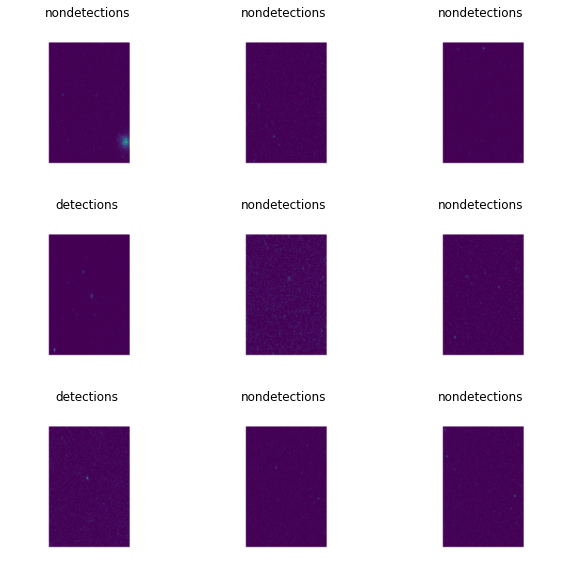

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 300, 300, 3)
(32,)


# Configure for performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize data

In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.003921569 1.0


# Create model

In [14]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile model

In [19]:
adamoptim = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=adamoptim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0

# Train model

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
72/72 [==============================] - 76s 1s/step - loss: nan - accuracy: 0.1329 - val_loss: nan - val_accuracy: 0.1357
Epoch 2/10
72/72 [==============================] - 75s 1s/step - loss: nan - accuracy: 0.1329 - val_loss: nan - val_accuracy: 0.1357
Epoch 3/10
72/72 [==============================] - 75s 1s/step - loss: nan - accuracy: 0.1329 - val_loss: nan - val_accuracy: 0.1357
Epoch 4/10
72/72 [==============================] - 75s 1s/step - loss: nan - accuracy: 0.1329 - val_loss: nan - val_accuracy: 0.1357
Epoch 5/10
72/72 [==============================] - 75s 1s/step - loss: nan - accuracy: 0.1329 - val_loss: nan - val_accuracy: 0.1357
Epoch 6/10
72/72 [==============================] - 75s 1s/step - loss: nan - accuracy: 0.1329 - val_loss: nan - val_accuracy: 0.1357
Epoch 7/10
72/72 [==============================] - 75s 1s/step - loss: nan - accuracy: 0.1329 - val_loss: nan - val_accuracy: 0.1357
Epoch 8/10
72/72 [==============================] - 75s 1s/ste

# Visualize results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile + re-train model

In [ ]:
model.compile(optimizer=adamoptim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Try on new data

In [ ]:
fits_to_png("/srv/scratch/zhutchen/g3rassimages_eco/RASS-Int_Soft_grp10006_ECO05513.fits")
eco5492path = "/srv/scratch/zhutchen/g3rassimages_eco/RASS-Int_Soft_grp10006_ECO05513.png"
#eco5492 = tf.keras.utils.get_file(eco5492path)

img = keras.preprocessing.image.load_img(
    eco5492path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)